<a href="https://colab.research.google.com/github/LeoMSgit/Extrator-de-Parametros-Analise-Hemograma-e-Bioquimico/blob/main/Google%20Colab%20(Cloud)%20-%20Extrator_de_Par%C3%A2metros_An%C3%A1lise_de_Hemograma_e_Bioqu%C3%ADmico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMO UTILIZAR

1 - Acesse o sub-menu "Arquivos" na barra lateral

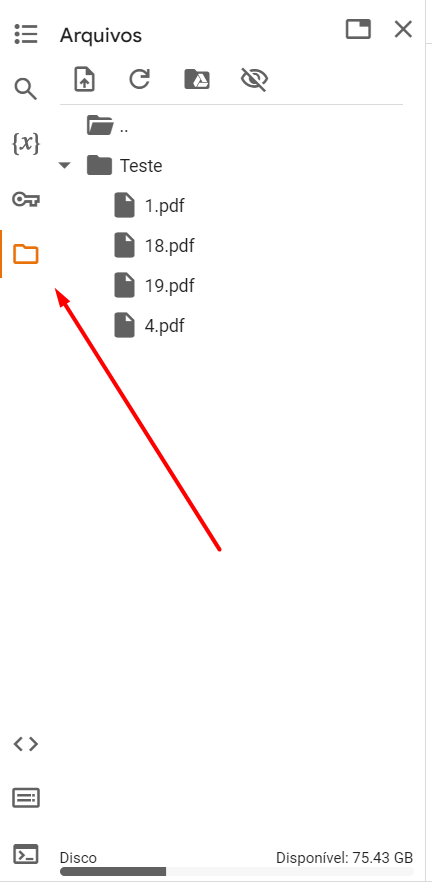

2 - Arraste os arquivos PDF para a pasta ou crie uma nova pasta

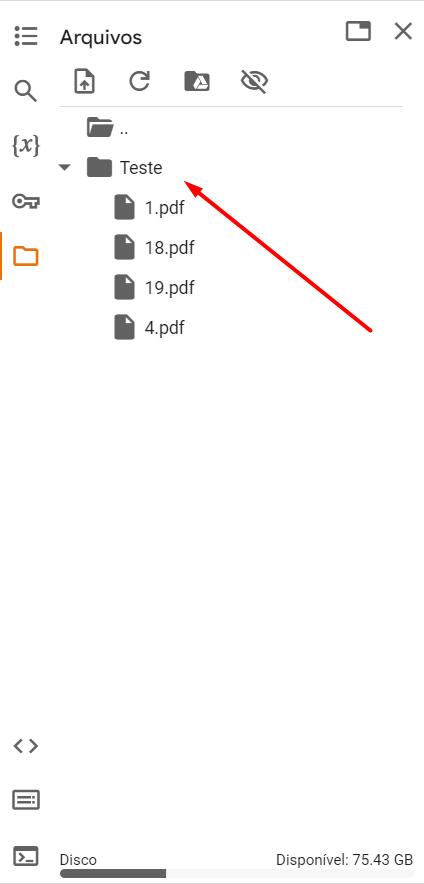

3 - Copie o caminho da pasta clicando com o botão direito nela ou clicando nos 3 pontos à direita da pasta

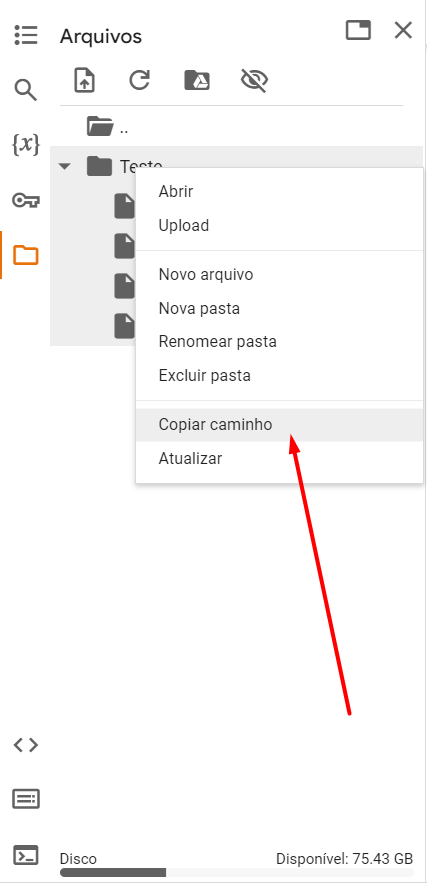

4 - Execute a célula "Instalar Bibliotecas" para instalar as bibliotecas necessárias


5 - Execute a célula "Insira caminho da pasta", cole o caminho da pasta copiada e pressione ENTER

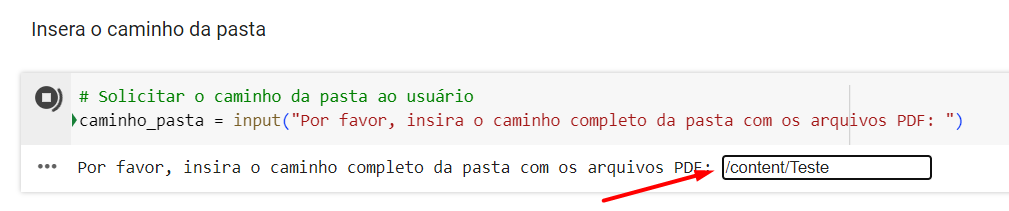

6 - Execute a célula "Execute o programa" para que os PDFs sejam lidos e o arquivo em Excel criado


7 - O arquivo Excel será criado e estará disponível para download no sub-menu "Arquivos" da barra lateral


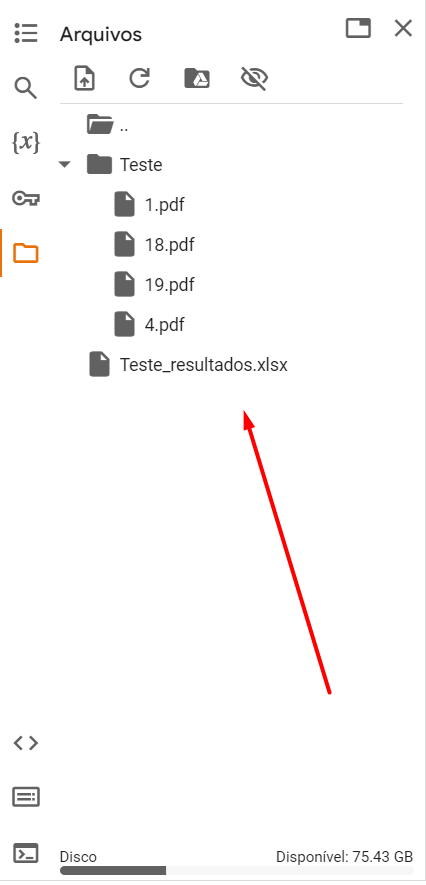



# Instalar bibliotecas

In [ ]:
!pip install PyPDF2 openpyxl

import os
import pandas as pd
import PyPDF2
import re
from openpyxl import load_workbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.4 MB/s eta 0:00:00


# Insira caminho da pasta

In [ ]:
# Solicitar o caminho da pasta ao usuário
caminho_pasta = input("Por favor, insira o caminho completo da pasta com os arquivos PDF: ")

Por favor, insira o caminho completo da pasta com os arquivos PDF: /content/1


# Execute o programa

Se desejar realizar uma nova extração repita os passo à partir do passo anterior

In [ ]:
# Verificar se o caminho da pasta é válido
if not os.path.exists(caminho_pasta):
    print(f"O caminho fornecido '{caminho_pasta}' não é válido.")
    exit()

# Lista de parâmetros
parametros = [
    "ERITROCITOS", "HEMOGLOBINA", "HEMATÓCRITO", "V.C.M", "H.C.M", "C.H.C.M",
    "PLAQUETAS", "LEUCÓCITOS TOTAIS", "BASTONETES", "SEGMENTADOS", "LINFÓCITOS",
    "MONÓCITOS", "EOSINÓFILOS", "BASÓFILOS", "ALBUMINA", "BILIRRUBINA DIRETA",
    "BILIRRUBINA TOTAL", "CK", "CREATININA", "FOSFATASE ALCALINA", "GGT",
    "PROTEINA TOTAL", "AST", "ALT", "UREIA", "BILIRRUBINA INDIRETA"
]

# DataFrame para armazenar os parâmetros na primeira coluna
df_final = pd.DataFrame({'PARÂMETROS': parametros})

# Processar todos os PDFs da pasta
arquivos_pdf = [f for f in os.listdir(caminho_pasta) if f.endswith('.pdf')]


# Função para extrair valores com regex
def extrair_valor(regex, texto):
    match = re.search(regex, texto, re.IGNORECASE)
    return match.group(1).replace(',', '.') if match else None


# Loop para processar cada arquivo PDF
for nome_pdf in arquivos_pdf:
    caminho_pdf = os.path.join(caminho_pasta, nome_pdf)

    # Abrir o arquivo PDF
    with open(caminho_pdf, 'rb') as file:
        reader = PyPDF2.PdfReader(file)

        # Extração de texto da primeira página
        page1 = reader.pages[0]
        text1 = page1.extract_text() or ""

        # Extração de texto da segunda página (se houver)
        if len(reader.pages) > 1:
            page2 = reader.pages[1]
            text2 = page2.extract_text() or ""
        else:
            text2 = ""

    # Criando uma lista para armazenar os resultados
    resultados = []

    # Extraindo valores da primeira página
    resultados.append(extrair_valor(r"ERITROCITOS?\s+([\d.,]+)\s+m", text1))
    resultados.append(extrair_valor(r"HEMOGLOBINA\s+([\d.,]+)\s+g/dL", text1))
    resultados.append(extrair_valor(r"HEMATÓCRITO\s+([\d.,]+)\s+%", text1))
    resultados.append(extrair_valor(r"V\.C\.M\s+([\d.,]+)\s+fl", text1))
    resultados.append(extrair_valor(r"H\.C\.M\s+([\d.,]+)\s+pg", text1))
    resultados.append(extrair_valor(r"C\.H\.C\.M\s+([\d.,]+)\s+%", text1))
    resultados.append(extrair_valor(r"PLAQUETAS\s+([\d.,]+)\s+µL", text1))
    resultados.append(extrair_valor(r"LEUCÓCITOS TOTAIS\s+([\d.,]+)\s+/mm³", text1))
    resultados.append(extrair_valor(r"BASTONETES\s+([\d.,]+)\s+(%|/mm³)", text1))
    resultados.append(extrair_valor(r"SEGMENTADOS\s+([\d.,]+)\s+(%|/mm³)", text1))
    resultados.append(extrair_valor(r"LINFÓCITOS\s+([\d.,]+)\s+(%|/mm³)", text1))
    resultados.append(extrair_valor(r"MONÓCITOS\s+([\d.,]+)\s+(%|/mm³)", text1))
    resultados.append(extrair_valor(r"EOSINÓFILOS\s+([\d.,]+)\s+(%|/mm³)", text1))
    resultados.append(extrair_valor(r"BASÓFILOS\s+([\d.,]+)\s+(%|/mm³)", text1))

    # Extraindo valores da segunda página
    resultados_second_page = re.findall(r"RESULTADO\.+:\s+([\d,.]+)", text2)

    # Associe os resultados da segunda página com os parâmetros da lista a partir de "ALBUMINA"
    for i, resultado in enumerate(resultados_second_page):
        if i < len(parametros) - 14:  # ajuste para os últimos parâmetros
            resultados.append(resultado.replace(',', '.'))

    # Adicionar os resultados como uma nova coluna ao DataFrame
    df_final[nome_pdf] = pd.Series(resultados)

# Nome do arquivo Excel com base no nome da pasta
nome_pasta = os.path.basename(os.path.normpath(caminho_pasta))
nome_arquivo_excel = f'{nome_pasta}_resultados.xlsx'

# Salvar o DataFrame em um arquivo Excel com os dados na vertical
df_final.to_excel(nome_arquivo_excel, index=False)

# Ajustar a largura da coluna A (PARÂMETROS)
wb = load_workbook(nome_arquivo_excel)
ws = wb.active
ws.column_dimensions['A'].width = 20

# Salvar o arquivo novamente após ajustar a largura da coluna
wb.save(nome_arquivo_excel)

print(f"Arquivo Excel '{nome_arquivo_excel}' gerado com sucesso!")

Arquivo Excel '1_resultados.xlsx' gerado com sucesso!
